In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
link = 'https://raw.githubusercontent.com/interviewquery/takehomes/stripe_1/stripe_1/product_usage.csv'
prod_usage = pd.read_csv(link,usecols=['Merchant','Date','Product','Event','Count of events','Usd Amount'])

In [3]:
prod_usage.sample(n=5)

,Merchant,Date,Product,Event,Count of events,Usd Amount
60,39rrckrzfr,01/12/2013,Recurring,Subscription.Charge,149.0,148851.0
439,gtey5htzkt9,01/09/2013,Recurring,Subscription.Charge,351.0,175149.0
1262,NaN,NaN,NaN,NaN,NaN,NaN
299,awzc15rk9,01/04/2014,Basic API,Charge,1702.0,170200.0
733,rczsldz33di,01/12/2013,Cart,Cart.PaymentSubmit,89.0,279641.0


In [4]:
prod_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446 entries, 0 to 1445
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Merchant         1252 non-null   object 
 1   Date             1252 non-null   object 
 2   Product          1252 non-null   object 
 3   Event            1252 non-null   object 
 4   Count of events  1252 non-null   float64
 5   Usd Amount       598 non-null    float64
dtypes: float64(2), object(4)
memory usage: 67.9+ KB


In [5]:
merchants = pd.read_csv('https://raw.githubusercontent.com/interviewquery/takehomes/stripe_1/stripe_1/segmentation.csv')

In [6]:
merchants.sample(5)

,Merchant,Segment
27,u9nzlgqr529,Platform
14,gtey5htzkt9,SaaS
20,m6jyvblc8fr,SaaS
4,4p36czyqfr,Platform
25,rczsldz33di,E-Commerce Store


**Product Usage Table:**

|Label| Description|
| - | :- |  
|`merchant`| This is the unique ID of each Stripe user |
|`date`| Data is aggregated up to the month level for each Stripe user.|
|`product`| This is the Stripe product that the user is using to charge their customers.|
|`event`| This is an action within a product. For more details on how products are used, see "segment details" below|
|`count of events`|       |
|`usd_amount`|Total amount in cents and USD that was processed for that API call|

**Segment Table:**

This is a mapping of merchant IDs to the user segmentation we have.

|Label| Description|
| - | :- | 
|`saas`| These businesses serve SaaS products which means they primarily charge their customers on a recurring basis (usually monthly). We want them to use our Subscriptions payments product to charge regularly on a time interval.|
|`ecommerce` | These businesses use Stripe's shopping cart product and primarily sell physical or digital goods online. |
|`platforms` | These users are platforms upon which other users can sign up and charge for services through the Stripe API. Examples would include ridesharing services, delivery services, etc. (e.g. Lyft, Task Rabbit, Instacart) |

In [150]:
prod_usage.isnull().sum()

Merchant             0
Date                 0
Product              0
Event                0
Count of events      0
Usd Amount         654
Amount             654
Segment              0
cohort_month         0
months_since         0
month                0
dtype: int64

In [8]:
prod_usage.dropna(axis=0,how='all',inplace=True)

In [9]:
prod_usage.isnull().sum()

Merchant             0
Date                 0
Product              0
Event                0
Count of events      0
Usd Amount         654
dtype: int64

In [10]:
prod_usage['Merchant'].nunique()

33

In [11]:
prod_usage['Amount'] = round(prod_usage['Usd Amount']/100,0)

In [12]:
prod_usage = prod_usage.merge(merchants,on='Merchant',how='inner')

In [13]:
prod_usage['Date']=pd.to_datetime(prod_usage['Date'],dayfirst=True)

In [14]:
prod_usage[prod_usage['Merchant']=='wtnlnqrrudi'].groupby('Event')['Date'].min()

Event
Cart.AddItem         2013-04-01
Cart.Checkout        2013-04-01
Cart.PaymentSubmit   2013-04-01
Cart.ViewItem        2013-04-01
Name: Date, dtype: datetime64[ns]

In [15]:
prod_usage.groupby(['Segment','Product']).agg(no_of_merchants=('Merchant','nunique'),
                                             avg_events=('Count of events',np.mean),
                                             avg_dollars=('Usd Amount','mean'),
                                             first_month=('Date',min))

no_of_merchants    avg_events   avg_dollars  \
Segment          Product                                                     
E-Commerce Store Cart                       13  13696.787844  2.561976e+06   
Platform         Marketplaces                9   2584.663366  7.584146e+06   
SaaS             Basic API                   7    695.653846  1.108688e+06   
                 Recurring                  10   1239.920000  4.884847e+05   

                              first_month  
Segment          Product                   
E-Commerce Store Cart          2013-01-01  
Platform         Marketplaces  2013-01-01  
SaaS             Basic API     2013-01-01  
                 Recurring     2013-05-01

In [16]:
merchants['Segment'].value_counts()

E-Commerce Store    13
SaaS                11
Platform             9
Name: Segment, dtype: int64

In [17]:
prod_usage['Date'].agg(['min','max'])

min   2013-01-01
max   2014-12-01
Name: Date, dtype: datetime64[ns]

Text(0.5, 0, 'Total Processed')

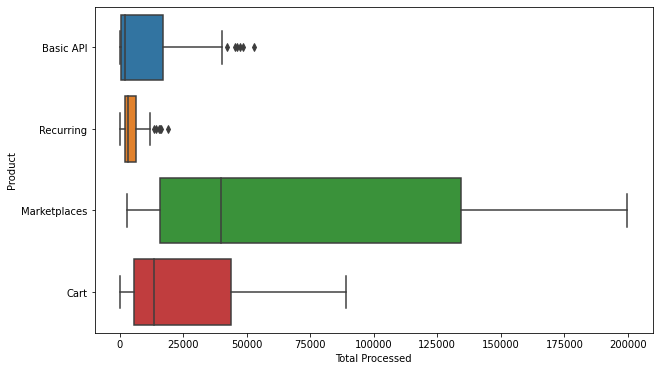

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(data=prod_usage.dropna(),y='Product',x='Amount')
plt.xlabel('Total Processed')

In [19]:
sns.set()

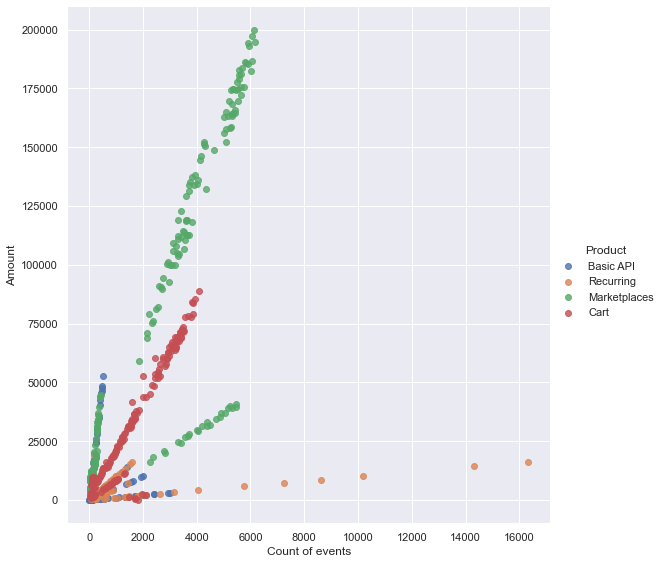

In [20]:
sns.lmplot(data=prod_usage.dropna(axis=0),y='Amount',x='Count of events',
           hue='Product',fit_reg=False,height=8)

Text(0.5, 1.0, 'Distribution of Events Count per Product for SaaS customers')

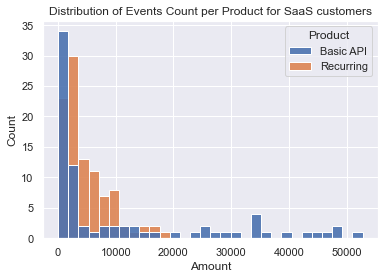

In [21]:
sns.histplot(data=prod_usage[prod_usage['Segment']=='SaaS'],x='Amount',hue='Product',bins=30,alpha=0.9)
plt.title('Distribution of Events Count per Product for SaaS customers')

Text(0.5, 1.0, 'Events Count for Platform Users')

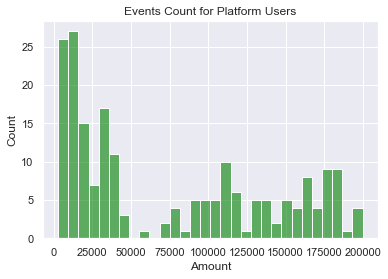

In [22]:
sns.histplot(data=prod_usage[prod_usage['Segment']=='Platform'],x='Amount',bins=30,alpha=0.6,color='Green')
plt.title('Events Count for Platform Users')

Text(0.5, 1.0, 'Events Count for Ecom Users')

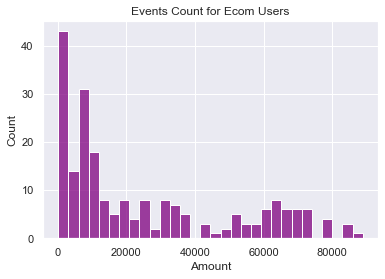

In [23]:
sns.histplot(data=prod_usage[prod_usage['Segment']=='E-Commerce Store'],x='Amount',bins=30,color='Purple')
plt.title('Events Count for Ecom Users')

In [24]:
merchant_stat = (
        prod_usage.dropna(how='any')
                  .groupby(['Merchant','Segment']).agg(cohort_month=('Date',min),
                                                       active_months=('Date','nunique'),
                                                       avg_payment_size=('Amount','mean'),
                                                       products_used=('Product','nunique'),
                                                       distinct_events=('Event','nunique'),
                                                       avg_event_count=('Count of events','mean'))
                  .reset_index()
                  .round({'avg_payment_size':0,'avg_event_count':0})
            )

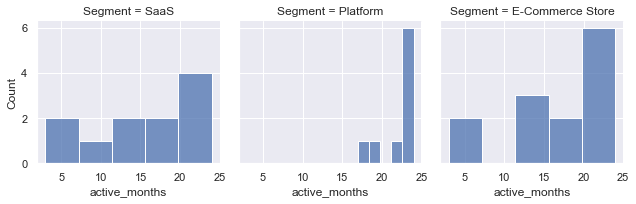

In [25]:
g = sns.FacetGrid(merchant_stat, col="Segment")
g.map(sns.histplot, "active_months",bins=5)

In [26]:
prod_usage = prod_usage.merge(merchant_stat[['Merchant','cohort_month']],on='Merchant',how='inner')

In [27]:
prod_usage['months_since'] = round((prod_usage['Date']-prod_usage['cohort_month']).dt.days/30,0)+1

### Cohort Analysis

In [28]:
removed_non_payments = prod_usage.dropna(axis=0,how='any')
grouping = removed_non_payments.groupby(['cohort_month','months_since','Segment'])
txns_per_cohort = grouping['Amount'].mean().round(0).reset_index()
txns_per_cohort['cohort_month'] = txns_per_cohort['cohort_month'].dt.strftime('%Y-%m')
saas = txns_per_cohort[txns_per_cohort['Segment']=='SaaS']
saas.pivot_table(index='cohort_month',values='Amount',columns='months_since')

months_since,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
cohort_month,,,,,,,,,,,,,,,,,,,,,
2013-01,5086.0,5838.0,6487.0,5476.0,7197.0,6364.0,9018.0,9718.0,9286.0,10934.0,...,12577.0,12833.0,13401.0,15782.0,15127.0,16941.0,17466.0,17806.0,18407.0,19869.0
2013-05,568.0,621.0,921.0,1024.0,1411.0,1341.0,1497.0,1771.0,1804.0,1942.0,...,5765.0,7236.0,8612.0,10200.0,14331.0,16325.0,NaN,NaN,NaN,NaN
2013-06,4168.0,2437.0,2312.0,2944.0,3648.0,4868.0,5278.0,4529.0,8044.0,4566.0,...,4734.0,8553.0,11686.0,12810.0,11557.0,NaN,NaN,NaN,NaN,NaN
2013-10,1079.0,1429.0,1489.0,684.0,1349.0,1179.0,959.0,609.0,410.0,210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11,6040.0,5640.0,5020.0,4640.0,6060.0,8660.0,10060.0,8060.0,10100.0,11060.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04,236.0,261.0,270.0,261.0,349.0,371.0,411.0,423.0,543.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07,2360.0,2850.0,3420.0,3350.0,4380.0,5000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,1285.0,1405.0,1525.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
ecom = txns_per_cohort[txns_per_cohort['Segment']=='E-Commerce Store']
ecom.pivot_table(index='cohort_month',values='Amount',columns='months_since')

months_since,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
cohort_month,,,,,,,,,,,,,,,,,,,,,
2013-01,19674.0,22650.0,20925.0,22768.0,23768.0,21474.0,24129.0,22916.0,21266.0,23026.0,...,25370.0,27472.0,21752.0,25628.0,22865.0,26349.0,22824.0,23642.0,25017.0,25974.0
2013-04,4485.0,3482.0,5068.0,5316.0,4650.0,6717.0,5974.0,6698.0,6001.0,7863.0,...,8764.0,8299.0,10877.0,8405.0,8760.0,8552.0,11637.0,NaN,NaN,NaN
2013-05,58015.0,56765.0,57863.0,63700.0,69163.0,77642.0,73665.0,63555.0,64678.0,70979.0,...,83786.0,78426.0,79241.0,88870.0,71558.0,84016.0,NaN,NaN,NaN,NaN
2013-08,1322.0,1436.0,1704.0,2286.0,2372.0,2821.0,23366.0,20675.0,17091.0,20785.0,...,16651.0,17984.0,17299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11,5084.0,4905.0,5352.0,7531.0,8070.0,7664.0,9396.0,9772.0,9722.0,10610.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12,32286.0,30490.0,33543.0,34802.0,48592.0,51953.0,43929.0,48990.0,53498.0,45164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01,33360.0,31165.0,26646.0,27835.0,34215.0,36762.0,25606.0,25851.0,30275.0,26755.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,8994.0,10934.0,11483.0,11737.0,13092.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,41565.0,52794.0,60225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
platform = txns_per_cohort[txns_per_cohort['Segment']=='Platform']
platform.pivot_table(index='cohort_month',values='Amount',columns='months_since')

months_since,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
cohort_month,,,,,,,,,,,,,,,,,,,,,
2013-01,72456.0,75863.0,81079.0,76904.0,83405.0,83826.0,87291.0,94817.0,98938.0,108254.0,...,107353.0,107894.0,105992.0,109183.0,112578.0,107395.0,111596.0,115551.0,107692.0,107086.0
2013-03,13257.0,13011.0,16059.0,20325.0,23171.0,26000.0,29499.0,31248.0,31145.0,29946.0,...,33135.0,33790.0,36009.0,44340.0,39712.0,43849.0,44703.0,35722.0,NaN,NaN
2013-06,2876.0,3166.0,3855.0,5461.0,6709.0,6491.0,7750.0,8011.0,8243.0,8045.0,...,8554.0,10142.0,10138.0,9486.0,11072.0,NaN,NaN,NaN,NaN,NaN
2013-08,3949.0,3711.0,5255.0,5630.0,8071.0,8050.0,7947.0,8826.0,8417.0,9836.0,...,12129.0,11114.0,11259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Transactions processed in USD per cohort month for SaaS merchants')

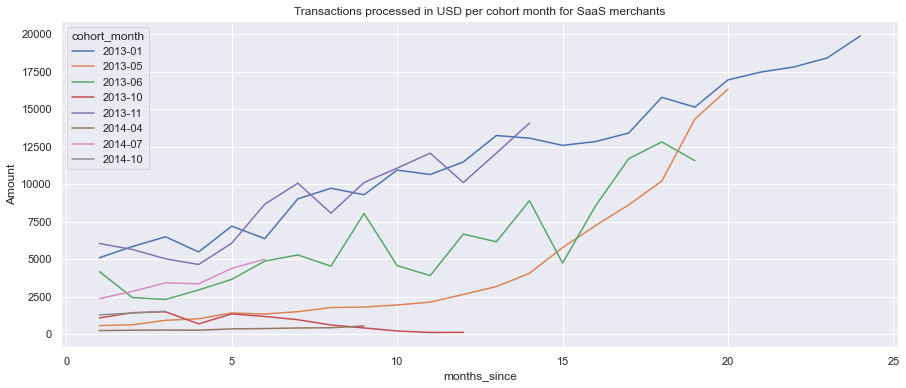

In [31]:
plt.figure(figsize=(15,6))
sns.lineplot(saas,x='months_since',y='Amount',hue='cohort_month')
plt.title('Transactions processed in USD per cohort month for SaaS merchants')

Text(0.5, 1.0, 'Transactions processed in USD per cohort for Ecom merchants')

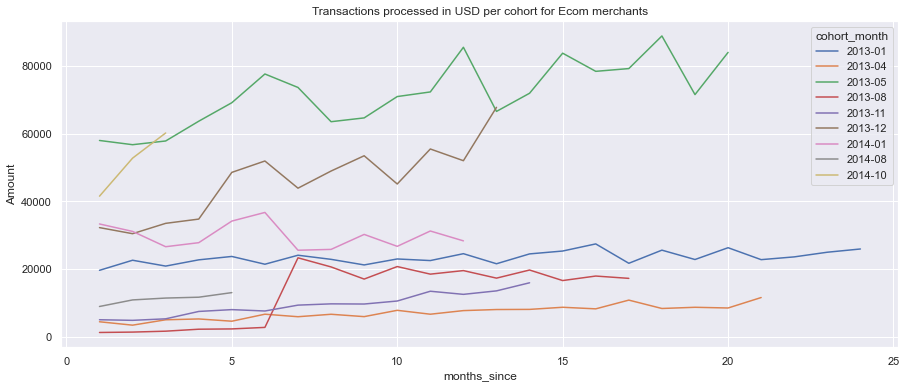

In [32]:
plt.figure(figsize=(15,6))
sns.lineplot(ecom,x='months_since',y='Amount',hue='cohort_month')
plt.title('Transactions processed in USD per cohort for Ecom merchants')

Text(0.5, 1.0, 'Transactions processed in USD per cohort month for Platform merchants')

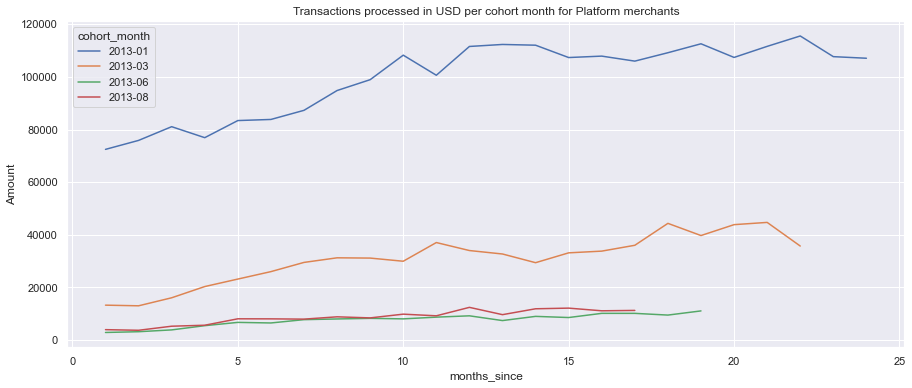

In [33]:
plt.figure(figsize=(15,6))
sns.lineplot(platform,x='months_since',y='Amount',hue='cohort_month')
plt.title('Transactions processed in USD per cohort month for Platform merchants')

In [34]:
spend_quartile = pd.qcut(merchant_stat['avg_payment_size'],q=4,labels=range(1,5))
merchant_stat['spend_quartile'] = spend_quartile

In [35]:
freq_quartile = pd.qcut(merchant_stat['avg_event_count'],q=4,labels=range(1,5))
merchant_stat['freq_quartile'] = freq_quartile

In [36]:
def compute_age_bucket(months):
    
    if months >= 20:
        age = 3
    elif months < 20 and months >= 10:
        age = 2
    else:
        age = 1
        
    return age

In [37]:
merchant_stat['age_bucket'] = merchant_stat['active_months'].apply(compute_age_bucket)

In [38]:
merchant_stat['rfm_score'] = merchant_stat[['spend_quartile','freq_quartile','age_bucket']].sum(axis=1)

Text(0.5, 1.0, 'Distribution of monthly average transactions processed for SaaS')

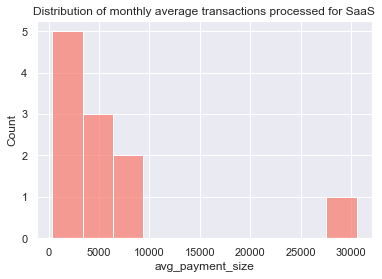

In [56]:
sns.histplot(data=merchant_stat[merchant_stat['Segment']=='SaaS'],x='avg_payment_size',color='salmon',bins=10)
plt.title('Distribution of monthly average transactions processed for SaaS')

Text(0.5, 1.0, 'Distribution of monthly average transactions processed for Platform/Marketplace')

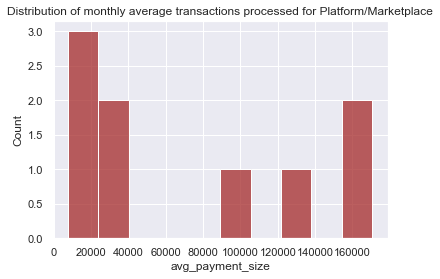

In [57]:
sns.histplot(data=merchant_stat[merchant_stat['Segment']=='Platform'],x='avg_payment_size',color='brown',bins=10)
plt.title('Distribution of monthly average transactions processed for Platform/Marketplace')

Text(0.5, 1.0, 'Distribution of average monthly transactions processed for Ecom')

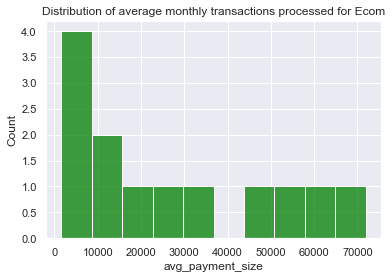

In [58]:
sns.histplot(data=merchant_stat[merchant_stat['Segment']=='E-Commerce Store'],x='avg_payment_size',
             color='green',bins=10)
plt.title('Distribution of average monthly transactions processed for Ecom')

In [69]:
merchant_stat.groupby('rfm_score').agg({'avg_payment_size':'median',
                                        'avg_event_count':'median',
                                        'active_months':'mean',
                                        'Merchant':'count'})

,avg_payment_size,avg_event_count,active_months,Merchant
rfm_score,,,,
3,1405.0,281.0,3.000000,1
4,1765.5,216.5,11.000000,4
5,5253.5,66.0,21.000000,4
6,8881.5,410.0,15.500000,4
7,7251.0,883.0,20.400000,5
8,30202.5,1562.5,16.333333,6
9,32715.0,1567.5,18.500000,2
10,30634.0,4151.0,24.000000,1
11,110788.0,3480.5,23.333333,6


In [75]:
merchant_stat[merchant_stat['rfm_score']==5]

,Merchant,Segment,cohort_month,active_months,avg_payment_size,products_used,distinct_events,avg_event_count,spend_quartile,freq_quartile,age_bucket,rfm_score
0,282t1vpldi,SaaS,2013-01-01,24,2912.0,2,2,29.0,1,1,3,5
5,50zxrqc9pb9,Platform,2013-06-01,19,7595.0,1,1,90.0,2,1,2,5
27,u9nzlgqr529,Platform,2013-08-01,17,8668.0,1,1,42.0,2,1,2,5
32,zz8yi2lz0k9,E-Commerce Store,2013-01-01,24,1627.0,1,1,155.0,1,1,3,5


In [97]:
prod_usage['month'] = prod_usage['Date'].dt.strftime('%Y-%m')

In [160]:
prod_usage['txn_per_event'] = prod_usage['Amount'] / prod_usage['Count of events']

<AxesSubplot:xlabel='month', ylabel='Count of events'>

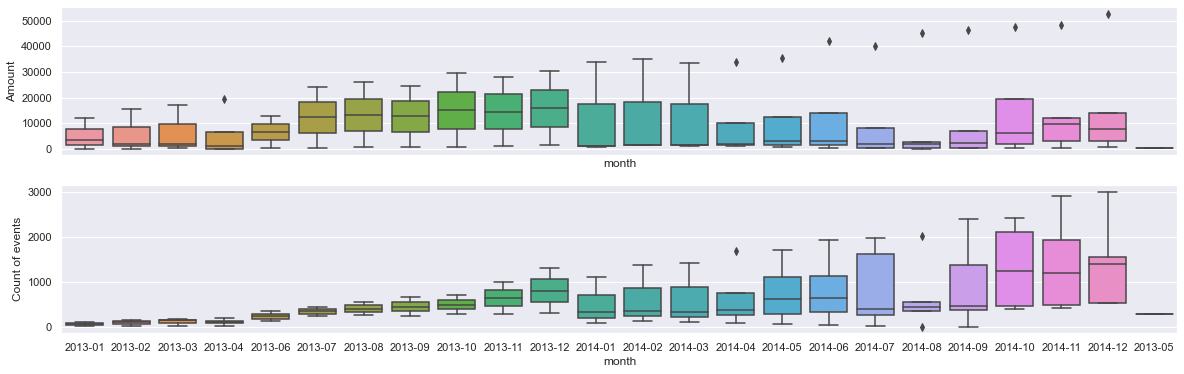

In [182]:
data = prod_usage[prod_usage['Product']=='Basic API']
months = data['month'].unique()

fig,axes = plt.subplots(2,1,figsize=(20,6),sharex=True)
sns.boxplot(data=data, x="month",y="Amount",ax=axes[0],order=months)
sns.boxplot(data=data, x="month",y="Count of events",ax=axes[1],order=months)
#fig.suptitle('USD$ Value & Volume of Transactions for SaaS API')

<AxesSubplot:xlabel='month', ylabel='Count of events'>

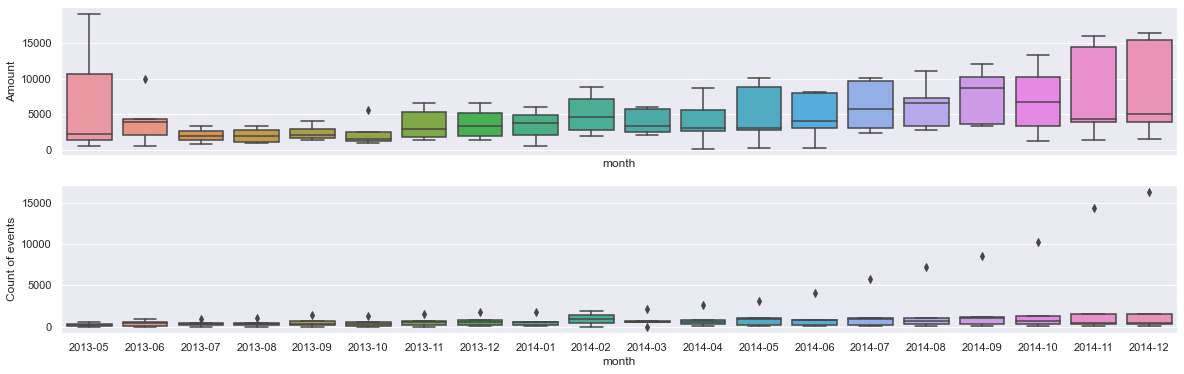

In [142]:
data = prod_usage[prod_usage['Product']=='Recurring']
months = data['month'].unique()
fig, axes = plt.subplots(2,1,figsize=(20,6),sharex=True)
sns.boxplot(data=data, x="month",y="Amount",order=months, ax=axes[0])
sns.boxplot(data=data, x="month",y="Count of events",order=months, ax=axes[1])

<AxesSubplot:xlabel='month', ylabel='Count of events'>

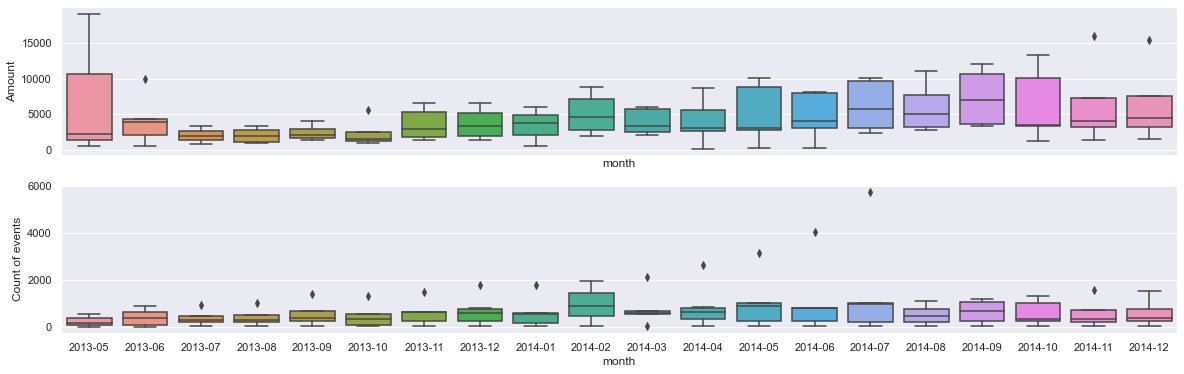

In [188]:
data = prod_usage[(prod_usage['Product']=='Recurring') & (prod_usage['Count of events']<=7000)]
months = data['month'].unique()
fig, axes = plt.subplots(2,1,figsize=(20,6),sharex=True)
sns.boxplot(data=data, x="month",y="Amount",order=months, ax=axes[0])
sns.boxplot(data=data, x="month",y="Count of events",order=months, ax=axes[1])

<AxesSubplot:xlabel='month', ylabel='Count of events'>

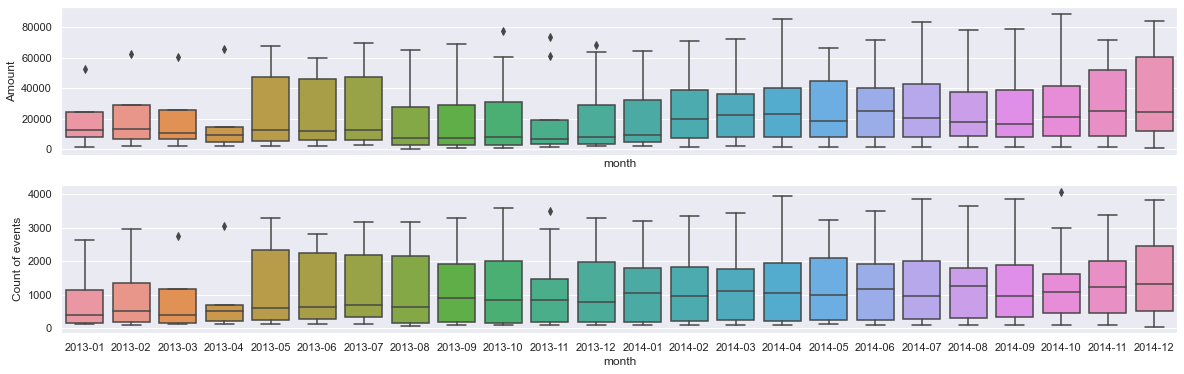

In [220]:
data = prod_usage[prod_usage['Product']=='Cart']
months = np.sort(data['month'].unique())#.sort()
fig, axes = plt.subplots(2,1,figsize=(20,6),sharex=True)
sns.boxplot(data=data, x="month",y="Amount",order=months, ax=axes[0])
sns.boxplot(data[data['Event']=='Cart.PaymentSubmit'], x="month",y="Count of events", ax=axes[1],order=months)
#plt.title('Monthly $ Value of Transactions Processed in Ecommerce')

<AxesSubplot:xlabel='month', ylabel='Count of events'>

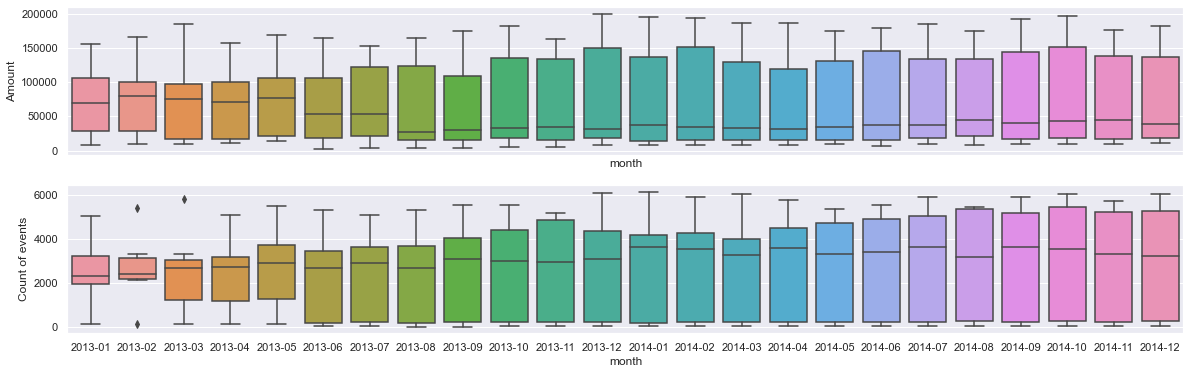

In [151]:
data = prod_usage[prod_usage['Product']=='Marketplaces']
months = np.sort(data['month'].unique())
fig, axes = plt.subplots(2,1,figsize=(20,6),sharex=True)
sns.boxplot(data=data, x="month",y="Amount", ax=axes[0],order=months)
sns.boxplot(data=data, x="month",y="Count of events", ax=axes[1],order=months)

In [171]:
monthly_transactions = (
    prod_usage.dropna(how='any')
              .groupby(['month','Product'])
              .agg({'Amount':'sum','Count of events':'sum'})
              .reset_index())
monthly_transactions['txns_per_event'] = monthly_transactions['Amount'] / monthly_transactions['Count of events']

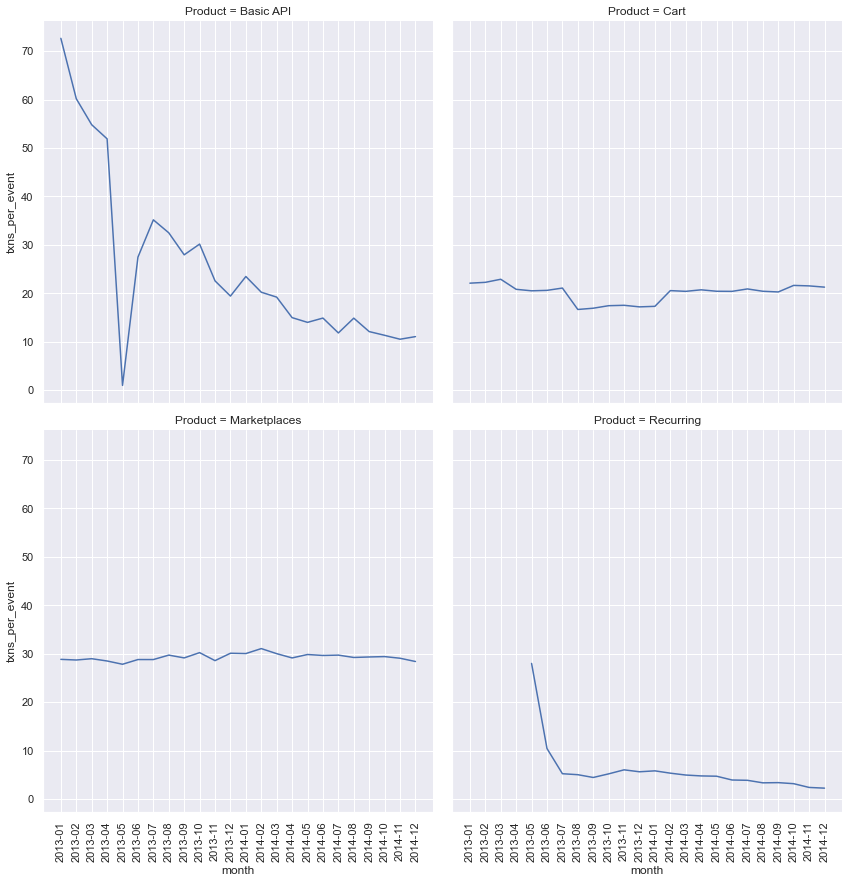

In [183]:
fig = sns.FacetGrid(monthly_transactions,col='Product',col_wrap=2,height=6)
fig.map(sns.lineplot,"month","txns_per_event")
fig.set_xticklabels(rotation=90)

In [203]:
prod_usage[(prod_usage['Product']=='Cart')]['Event'].unique()

array(['Cart.AddItem', 'Cart.Checkout', 'Cart.PaymentSubmit',
       'Cart.ViewItem'], dtype=object)